In [1]:
import random as rn
rn.seed(1254)

import numpy as np
#np.random.seed(1515)

import h5py
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

import tensorflow as tf
tf.set_random_seed(2)

config = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1 
)

config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
sess = tf.Session(graph= tf.get_default_graph(), config=config) 
    
import keras 
from keras import backend as K
from keras.models import load_model
K.set_learning_phase(1)

Using TensorFlow backend.


In [2]:
plt.rcParams['figure.figsize'] = (14, 6)

In [3]:
projectspace = '/vol/vssp/AcousticEventsDetection/DLGdansk/UrbanSound/'
#modelpath = os.path.join(projectspace,'models','crnn_epoch_156_val_loss_1.3890.hdf5')
modelpath = os.path.join(projectspace,'models','cnn_epoch_032_val_loss_1.5498.hdf5')
hdf5_path = os.path.join(projectspace,'dataset.hdf5')

In [4]:
# LOAD DATA
hf = h5py.File(hdf5_path, 'r')
X_train = np.array(hf.get('X_train') )
y_train = np.array(hf.get('y_train'))
X_val =  np.array(hf.get('X_val'))
y_val= np.array(hf.get('y_val'))
X_test = np.array(hf.get('X_test'))
y_test = np.array(hf.get('y_test'))

n_features= hf.get('n_features').value
n_frames=hf.get('max_length_samp').value
label_list= hf.get('label_list').value

In [5]:
model=load_model(modelpath)

In [6]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])
layer_dict.keys()

[u'dense_1',
 u'flatten_1',
 u'max_pooling2d_1',
 u'max_pooling2d_3',
 u'max_pooling2d_2',
 u'dropout_1',
 u'input_1',
 u'batch_normalization_2',
 u'batch_normalization_3',
 u'batch_normalization_1',
 u'conv2d_1',
 u'conv2d_3',
 u'conv2d_2']

In [25]:
layer_name = 'conv2d_3'
filter_index = 15
step =1

In [13]:
input_data = model.input

In [26]:
layer_output = layer_dict[layer_name].output
loss = K.mean(layer_output[:, filter_index, :, :])

# compute the gradient of the input picture wrt this loss
grads = K.gradients(loss, input_data)[0]

# normalization trick: we normalize the gradient
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

# this function returns the loss and grads given the input picture
iterate = K.function([input_data], [loss, grads])

In [27]:
input_data_gen = np.random.random((1, n_frames, n_features, 1))

for i in range(50):
    loss_value, grads_value = iterate([input_data_gen])
    input_data_gen += grads_value * step

    #print('Current loss value:', loss_value)
    if loss_value <= 0.:
       # some filters get stuck to 0, we can skip them
        break

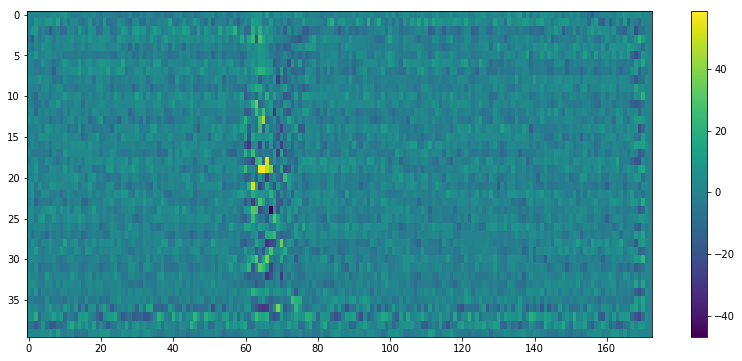

In [28]:
plt.imshow(input_data_gen[0,:,:,0].T, aspect='auto')
plt.colorbar()